In [1]:
from genome import Genome
genome = Genome('/Users/jpaggi/Downloads/MPRA/snps/hg19.fa')

KeyboardInterrupt: 

In [ ]:
import numpy as np
bases = ['A', 'C', 'G', 'T']
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
bps = []
with open('../preprocessing/') as fp:
    for line in fp:
        chrom, pos, _, _, _, strand = line.strip().split('\t')
        bps += [(chrom, int(pos), strand)]
print len(bps)

59359


In [11]:
cons = {}
with open('hg19.100way.phastCons.bp.bed') as fp:
    for line in fp:
        chrom, pos, _, score = line.strip().split()
        if chrom not in cons: cons[chrom] = {}
        cons[chrom][int(pos)] = float(score)

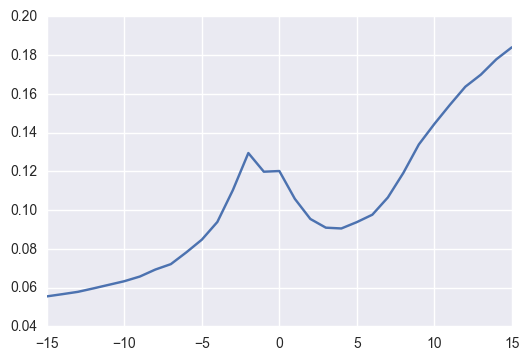

In [12]:
k = 15
meta = np.zeros((k*2 + 1,))
total = 0
missing = 0
for chrom, pos, strand in bps:
    for i in range(2*k + 1):
        idx = pos + i - k
        p = i if strand == '+' else 2*k - i
        if idx not in cons[chrom]:
            missing += 1
        meta[p] += cons[chrom][idx] if idx in cons[chrom] else 0
    total += 1
plt.plot(range(-k, k+1), meta / float(total))
plt.show()

In [12]:
counts = np.zeros((len(bases), ))
for chrom, pos, strand in bps:
    base = genome.get_seq(chrom, pos, pos + 1, strand)
    counts[bases.index(base)] += 1
print counts

[ 46565.   5015.   2807.   4972.]


In [13]:
count = 0
with open('introns.bed') as fp:
    for line in fp:
        chrom, start, end, _, _, strand = line.strip().split('\t')
        start, end = int(start), int(end)
        assert start > 0
        assert end > 0
        assert end > start, (start, end)
        if strand == '+': continue
        print genome.get_seq(chrom, int(start), int(start)+2, strand)
        count += 1
        if count > 5: break

CG
AG
AG
AG
AG
CG


In [14]:
bps = {}
with open('bps_introns.tsv') as fp:
    for line in fp:
        chrom, pos, _, _, _, strand, _, start, end = line.split('\t')[:9]
        pos, start, end = int(pos), int(start), int(end)
        # No hit!
        if start == -1: continue
            
        # Check if reasonable
        if strand == '+':
            dist = end - pos - 1
        else:
            dist = pos - start
            
        if not 5 < dist < 60: continue
        
        # Add branchpoint
        key = (chrom, pos, strand)
        if key not in bps: bps[key] = []
        if key not in bps[key]:
            bps[key] += [(start, end)]
print len(bps)

55658


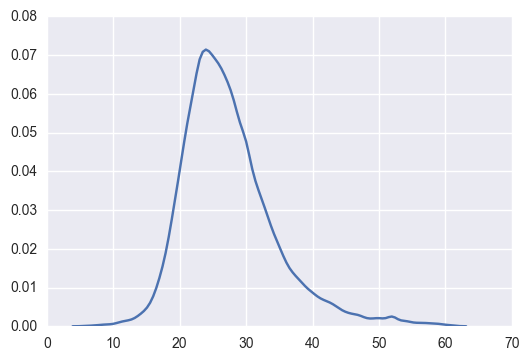

In [15]:
dists = []
for bp, introns in bps.items():
    start, end = introns[0]
    chrom, pos, strand = bp
    dists += [end - pos + 1] if strand == '+' else [pos - start]
sns.kdeplot(np.array(dists))

In [16]:
for bp, introns in bps.items()[:100]:
    start, end = introns[0]
    chrom, pos, strand = bp
    if strand == '+':
        begin, stop = pos, end
    else:
        begin, stop = start, pos
    print genome.get_seq(chrom, begin, stop, strand)

ACCATTTTTTTTCTTTCTGCTTTCTCCATATCTTAG
TGATGTTTCCCCTCTATTTGGCAG
ACCTCCTCCCTCTGTGCTGCAG
GCATTTCTTTTAAAATCACTGTTTTGTTTTAG
GGGCTTAACCTCTCATGCTCTCATGTTGAAAG
AACTCAGGCTTGTTTTTTTTCATGACATGACAG
TTATTTTCTGTCTACAG
ACTGCTTTGCTTTGCTTTACAG
AGCAACAGTACCCCATTCCAG
GTTGTTAATGCCTTACCTTTTATTTCCAG
AGCAGTTTACCTCTCCCTCCTGTCTGCCCACCAG
TGTGACCTGTCTCCCCTGCCTCCTTCTAG
GCCTTTTGTTTTCTCCTCATATTTTATTGTTTTCATGTAG
CACTCCCATCTTTCTGCTTTTTCAAAG
CACCTCTCCCTGCTTGACCCTCAG
ATTTTTATTTTTATTTCAG
CCGTGCCCTGTCCCCACAG
TCTGCCCCATATTATTGTGCCTTCTCCAG
ATTTTTTTTATAATCATTTTGTTCTGTCCTCTGCCTTGATTTGCTATAG
AGATTCTGGTTTTTCTCCGCAG
AATTTCTCTGTCCTTCTAATAG
ACTGTTGCGTCCTTCCCTCCCCTCAG
AAACTGGTTTCTCTCTCTCCTTGTAG
ACCTTGCCCATCTTCTCCCCCTAG
ACTTTGCCTCGATCTTTCTCAG
AATGGTGCTCTGAACTGCGGCCTCTGTTTCAG
ACAGATAAGCATGTTTTGGCTTGTTTTTATAG
CCTACCCCCTGCATTTCTGGTCTCCAG
AGAGCCCCCCTGCCAACTGCACTCTCTACAG
ACAGCTGTGTTTGCTCCCATGACAG
AATGATTTTACTCCCTTTTTTTAAAG
CTCATCCTCTTCTGCTTCTCAG
TGAGGTTTGTCTCTGGCTCTTTCCTCTGACTAG
ACTCTGCTGGTGTTGGTTTCAG
ATCACTTTTTGGTTCTTTTTAG
ACTCTTCATGTAT

# Nucleotide frequencies

In [9]:
counts = np.zeros((len(bases),))
for bp, introns in bps.items():
    start, end = introns[0]
    chrom, pos, strand = bp
    if strand == '+':
        begin, stop = pos, end
    else:
        begin, stop = start, pos
    begin += 3
    stop += -3
    seq =  genome.get_seq(chrom, begin, stop, strand)
    for char in seq:
        counts[bases.index(char)] += 1
print bases
print counts

['A', 'C', 'G', 'T']
[ 143872.  335117.  153152.  532898.]


# Motifs for fixed width

In [16]:
for i in range(15, 40):
    count = 0
    with open('seqs' + str(i), 'w') as out:
        for bp, introns in bps.items():
            start, end = introns[0]
            chrom, pos, strand = bp
            if strand == '+':
                begin, stop = pos, end
            else:
                begin, stop = start, pos
            if stop - begin != i: continue
            count += 1
            if count == 1000: break
            seq =  genome.get_seq(chrom, begin, stop, strand)
            out.write(seq + '\n')

In [26]:
count = 0
with open('bps', 'w') as out:
    for bp, introns in bps.items():
        start, end = introns[0]
        chrom, pos, strand = bp
        if chrom == 'chr1': continue
        if strand == '+': continue
        if strand == '+':
            begin, stop = pos-5, pos + 6
        else:
            begin, stop = pos-5, pos + 6
        #if stop - begin != i: continue
        count += 1
        if count == 1000: break
        seq =  genome.get_seq(chrom, begin, stop, strand)
        out.write(seq + '\n')

# Di/ tri - nucleotide Enrichments

In [61]:
nucleotide_counts = np.ones((len(bases),))
for bp, introns in bps.items():
    start, end = introns[0]
    chrom, pos, strand = bp
    if strand == '+':
        begin, stop = pos+5, end-5
    else:
        begin, stop = start+5, pos-5
    seq =  genome.get_seq(chrom, begin, stop, strand)
    for char in seq:
        nucleotide_counts[bases.index(char)] += 1
print bases
print nucleotide_counts

['A', 'C', 'G', 'T']
[ 106001.  274228.  115938.  446399.]


In [62]:
dinucleotide_counts = np.ones((len(bases)*len(bases),))
for bp, introns in bps.items():
    start, end = introns[0]
    chrom, pos, strand = bp
    if strand == '+':
        begin, stop = pos+5, end-5
    else:
        begin, stop = start+5, pos-5
    seq =  genome.get_seq(chrom, begin, stop, strand)
    for i in range(len(seq)-1):
        idx = bases.index(seq[i]) * 4 + bases.index(seq[i+1])
        dinucleotide_counts[idx] += 1
print [bases[i / 4] + bases[i % 4] for i in range(16)]
print dinucleotide_counts

['AA', 'AC', 'AG', 'AT', 'CA', 'CC', 'CG', 'CT', 'GA', 'GC', 'GG', 'GT', 'TA', 'TC', 'TG', 'TT']
[  22167.   25006.    4550.   49813.   28190.   92302.    8759.  125682.
   12617.   28093.   17517.   54285.   33655.  114514.   74611.  195265.]


1.0 1.0


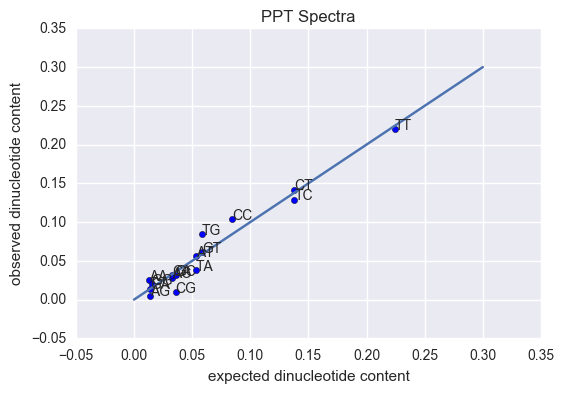

In [63]:
x = np.array([nucleotide_counts[i / 4] * nucleotide_counts[i % 4]
              for i in range(16)]) / sum(nucleotide_counts)**2
y = dinucleotide_counts / sum(dinucleotide_counts)

print sum(x), sum(y)

n = [bases[i / 4] + bases[i % 4] for i in range(16)]

fig, ax = plt.subplots()
ax.scatter(x, y)

for i, txt in enumerate(n):
    ax.annotate(txt, (x[i],y[i]))
    
plt.plot([0, .3], [0, .3])
plt.title('PPT Spectra')
plt.ylabel('observed dinucleotide content')
plt.xlabel('expected dinucleotide content')
plt.show()

In [64]:
trinucleotide_counts = np.ones((len(bases)**3,))
for bp, introns in bps.items():
    start, end = introns[0]
    chrom, pos, strand = bp
    if strand == '+':
        begin, stop = pos+5, end-5
    else:
        begin, stop = start+5, pos-5
    seq =  genome.get_seq(chrom, begin, stop, strand)
    for i in range(len(seq)-2):
        idx =  bases.index(seq[i]) * 16
        idx += bases.index(seq[i+1]) * 4
        idx += bases.index(seq[i+2])
        trinucleotide_counts[idx] += 1
print [bases[i / 16] + bases[(i%16) / 4] + bases[i % 4] for i in range(64)]
print trinucleotide_counts

['AAA', 'AAC', 'AAG', 'AAT', 'ACA', 'ACC', 'ACG', 'ACT', 'AGA', 'AGC', 'AGG', 'AGT', 'ATA', 'ATC', 'ATG', 'ATT', 'CAA', 'CAC', 'CAG', 'CAT', 'CCA', 'CCC', 'CCG', 'CCT', 'CGA', 'CGC', 'CGG', 'CGT', 'CTA', 'CTC', 'CTG', 'CTT', 'GAA', 'GAC', 'GAG', 'GAT', 'GCA', 'GCC', 'GCG', 'GCT', 'GGA', 'GGC', 'GGG', 'GGT', 'GTA', 'GTC', 'GTG', 'GTT', 'TAA', 'TAC', 'TAG', 'TAT', 'TCA', 'TCC', 'TCG', 'TCT', 'TGA', 'TGC', 'TGG', 'TGT', 'TTA', 'TTC', 'TTG', 'TTT']
[  5958.   4519.    696.   9977.   3279.   8551.   1006.  10799.    712.
   1247.    972.   1571.   4996.   9473.   8861.  22155.   3442.   9037.
   1027.  13109.  10364.  32267.   3529.  37369.    686.   2657.   1499.
   3548.   5701.  38566.  26057.  47160.   3736.   2832.    789.   4827.
   2793.  11060.   1055.  11908.   1971.   4956.   3846.   6130.   4312.
  16390.  10844.  20162.   6749.   6666.    458.  18360.   9384.  35633.
   2375.  59281.   7580.  16444.   9224.  38990.  16197.  44898.  23839.
  97119.]


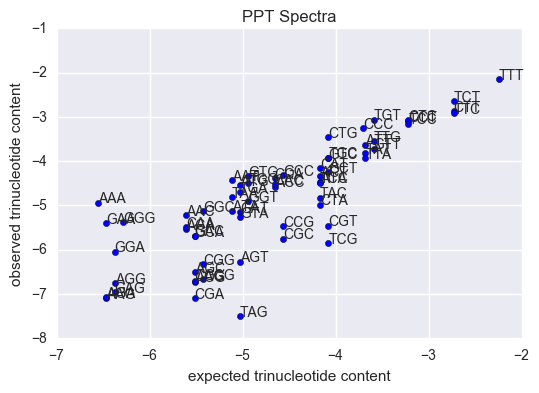

In [65]:
x = np.log(np.array([nucleotide_counts[i / 16]
              * nucleotide_counts[(i%16) / 4]
              * nucleotide_counts[i % 4]
              for i in range(64)]) / sum(nucleotide_counts)**3)
y = np.log(trinucleotide_counts / sum(trinucleotide_counts))

n = [bases[i / 16] + bases[(i%16) / 4] + bases[i % 4]
     for i in range(64)]

fig, ax = plt.subplots()
ax.scatter(x, y)

for i, txt in enumerate(n):
    ax.annotate(txt, (x[i],y[i]))
    
plt.title('PPT Spectra')
plt.ylabel('observed trinucleotide content')
plt.xlabel('expected trinucleotide content')
plt.show()

# Intronic spectrum

In [66]:
nucleotide_counts = np.ones((len(bases),))
for bp, introns in bps.items():
    start, end = introns[0]
    chrom, pos, strand = bp
    if strand == '+':
        begin, stop = pos-30, pos-5
    else:
        begin, stop = pos + 5, pos+30
    seq =  genome.get_seq(chrom, begin, stop, strand)
    for char in seq:
        nucleotide_counts[bases.index(char)] += 1
print bases
print nucleotide_counts

['A', 'C', 'G', 'T']
[ 319413.  316411.  347555.  408075.]


In [67]:
dinucleotide_counts = np.ones((len(bases)*len(bases),))
for bp, introns in bps.items():
    start, end = introns[0]
    chrom, pos, strand = bp
    if strand == '+':
        begin, stop = pos-30, pos-5
    else:
        begin, stop = pos + 5, pos+30
    seq =  genome.get_seq(chrom, begin, stop, strand)
    for i in range(len(seq)-1):
        idx = bases.index(seq[i]) * 4 + bases.index(seq[i+1])
        dinucleotide_counts[idx] += 1
print [bases[i / 4] + bases[i % 4] for i in range(16)]
print dinucleotide_counts

['AA', 'AC', 'AG', 'AT', 'CA', 'CC', 'CG', 'CT', 'GA', 'GC', 'GG', 'GT', 'TA', 'TC', 'TG', 'TT']
[  83021.   54221.   89889.   79750.   82086.   97722.   20476.  103945.
   74799.   74449.  101039.   84325.   66378.   78513.  120986.  124209.]


-44.5321379656 -45.3626481693


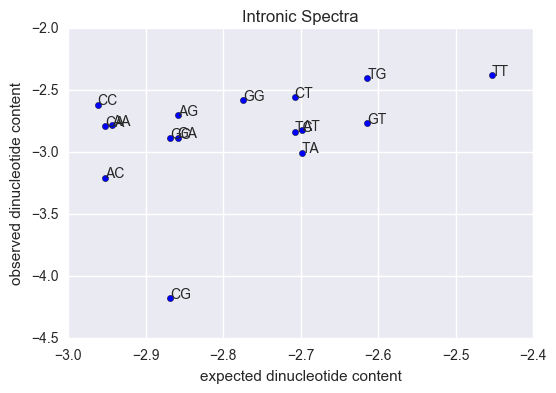

In [68]:
x = np.log(np.array([nucleotide_counts[i / 4] * nucleotide_counts[i % 4]
              for i in range(16)]) / sum(nucleotide_counts)**2)
y = np.log(dinucleotide_counts / sum(dinucleotide_counts))

print sum(x), sum(y)

n = [bases[i / 4] + bases[i % 4] for i in range(16)]

fig, ax = plt.subplots()
ax.scatter(x, y)

for i, txt in enumerate(n):
    ax.annotate(txt, (x[i],y[i]))
    
plt.title('Intronic Spectra')
plt.ylabel('observed dinucleotide content')
plt.xlabel('expected dinucleotide content')
plt.show()

In [69]:
trinucleotide_counts = np.ones((len(bases)**3,))
for bp, introns in bps.items():
    start, end = introns[0]
    chrom, pos, strand = bp
    if strand == '+':
        begin, stop = pos-30, pos-5
    else:
        begin, stop = pos + 5, pos+30
    seq =  genome.get_seq(chrom, begin, stop, strand)
    for i in range(len(seq)-2):
        idx =  bases.index(seq[i]) * 16
        idx += bases.index(seq[i+1]) * 4
        idx += bases.index(seq[i+2])
        trinucleotide_counts[idx] += 1
print [bases[i / 16] + bases[(i%16) / 4] + bases[i % 4] for i in range(64)]
print trinucleotide_counts

['AAA', 'AAC', 'AAG', 'AAT', 'ACA', 'ACC', 'ACG', 'ACT', 'AGA', 'AGC', 'AGG', 'AGT', 'ATA', 'ATC', 'ATG', 'ATT', 'CAA', 'CAC', 'CAG', 'CAT', 'CCA', 'CCC', 'CCG', 'CCT', 'CGA', 'CGC', 'CGG', 'CGT', 'CTA', 'CTC', 'CTG', 'CTT', 'GAA', 'GAC', 'GAG', 'GAT', 'GCA', 'GCC', 'GCG', 'GCT', 'GGA', 'GGC', 'GGG', 'GGT', 'GTA', 'GTC', 'GTG', 'GTT', 'TAA', 'TAC', 'TAG', 'TAT', 'TCA', 'TCC', 'TCG', 'TCT', 'TGA', 'TGC', 'TGG', 'TGT', 'TTA', 'TTC', 'TTG', 'TTT']
[ 26809.  12045.  19619.  21042.  17145.  14340.   3655.  17221.  21468.
  19282.  25539.  20125.  16473.  12356.  21507.  25381.  13389.  16787.
  29116.  19425.  23921.  30873.   6961.  31525.   2885.   4815.   6511.
   5392.  11236.  23563.  37517.  27250.  20902.  12651.  22380.  15827.
  18435.  25157.   5267.  22935.  22391.  24656.  30573.  20047.  13736.
  15384.  29091.  22208.  18340.  10487.  14772.  20170.  19312.  23891.
   3766.  28328.  24627.  22701.  33078.  35366.  22102.  24225.  27817.
  44403.]


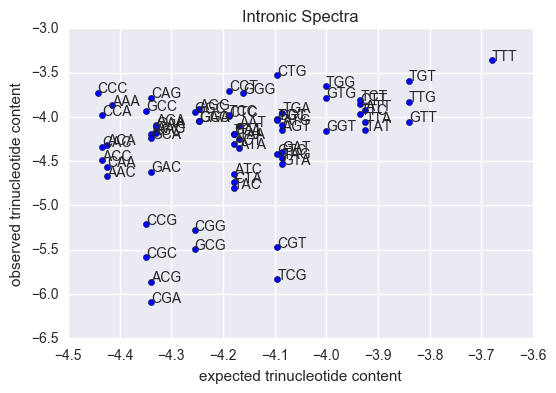

In [70]:
x = np.log(np.array([nucleotide_counts[i / 16]
              * nucleotide_counts[(i%16) / 4]
              * nucleotide_counts[i % 4]
              for i in range(64)]) / sum(nucleotide_counts)**3)
y = np.log(trinucleotide_counts / sum(trinucleotide_counts))

n = [bases[i / 16] + bases[(i%16) / 4] + bases[i % 4]
     for i in range(64)]

fig, ax = plt.subplots()
ax.scatter(x, y)

for i, txt in enumerate(n):
    ax.annotate(txt, (x[i],y[i]))

plt.title('Intronic Spectra')
plt.ylabel('observed trinucleotide content')
plt.xlabel('expected trinucleotide content')
plt.show()